In [7]:
import gym
import gc

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import seaborn as sns
import time

from IPython.display import clear_output, display

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

# suppress pandas warning
pd.options.mode.chained_assignment = None

# set seed
np.random.seed(0)

%matplotlib inline

In [10]:
colors = {'S': '#FFD700', 'F': '#ADD8E6', 'H': '#000000', 'G': '#32CD32'}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title='Frozen Lake Grid Space (4x4)'):
    gc.collect()
    squares = env.nrow
    
    plt.clf()
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=24, y=1.01)
    grid_size = int(np.sqrt(env.observation_space.n))
    
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            cell_type = env.desc[i, j].decode()
            color = colors[cell_type]
            ax.text(j, grid_size - i - 1, cell_type, ha='center', va='center', fontsize=20, color='black', zorder=3)
            # Add rounded rectangle representing the cell
            if cell_type == 'H':
                rect = Rectangle((j - 0.5, grid_size - i - 1 - 0.5), 1, 1, edgecolor='black', linewidth=2, zorder=2)
                ax.add_patch(rect)
            else:
                rect = Rectangle((j - 0.5, grid_size - i - 1 - 0.5), 1, 1, edgecolor='black', facecolor=color, linewidth=2, zorder=2)
                ax.add_patch(rect)
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
    # Set axis limits and labels
    ax.set_xlim(-0.5, grid_size - 0.5)
    ax.set_ylim(-0.5, grid_size - 0.5)
    ax.set_xticks(np.arange(-0.5, grid_size, 1))
    ax.set_yticks(np.arange(-0.5, grid_size, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(length=0)

    # Remove axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Set title
    ax.set_title(title, fontsize=24, pad=20)

    # Add a grid
    ax.grid(color='gray', linestyle='-', linewidth=0.5)

    # Equal aspect ratio
    ax.set_aspect('equal')

    # Remove padding
    plt.tight_layout(pad=0)

    # Adjust alpha (transparency) for black cells to create a faded effect
    for patch in ax.patches:
        if patch.get_facecolor() == (0, 0, 0, 1):  # Check if the patch color is black
            patch.set_alpha(0.3)  # Set the alpha value for faded effect

    # Show the plot
    plt.show()
    fig.savefig('C:/Users/sagni/Documents/Personal Files/CS7641/Assignment4/Images/Frozen_lake/' + title + '.png', dpi=600)
    
#plot_lake(env, policy)

In [3]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_score(env, policy, printInfo=False, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    if (printInfo):
        print('----------------------------------------------')
        print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
        print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
        print('----------------------------------------------')
  
    return ave_steps, std_steps, pct_fail

In [4]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy 

### Setup

<Figure size 640x480 with 0 Axes>

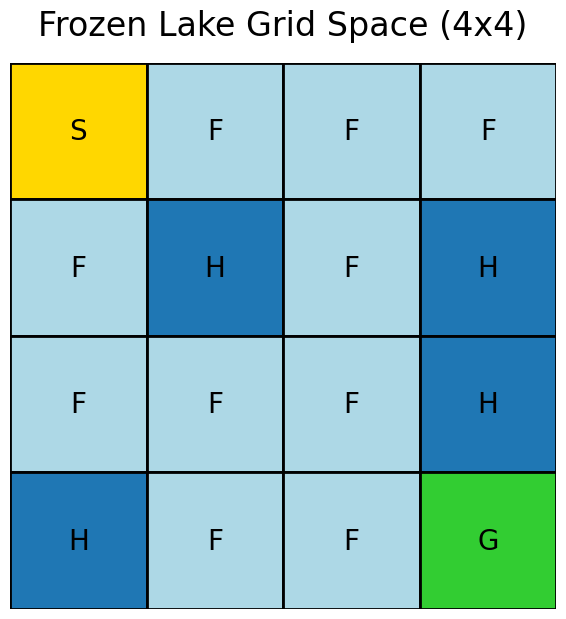

In [13]:
# Setup 4x4
env = gym.make('FrozenLake-v1').unwrapped

env.max_episode_steps=250

# Create transition and reward matrices from OpenAI P matrix
rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]

plot_lake(env)